Text(0.5, 1.0, 'Sensitivity (Averaged maximum) of layers')

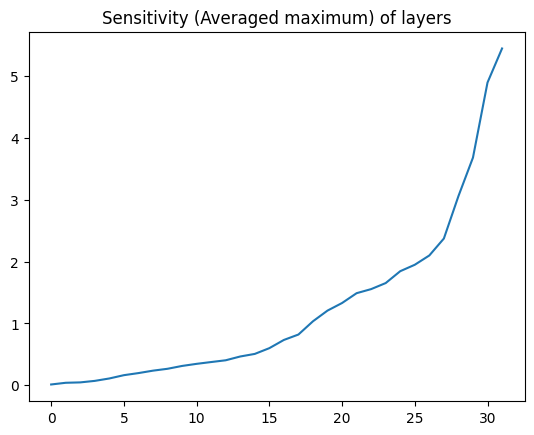

In [75]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

scores_path = '/home/nlyaly/projects/lm-evaluation-harness/results/moe/dfurman__Mixtral-8x7B-Instruct-v0.1/mrpc/rate_per_layer.scv'
htrace_path = '/home/nlyaly/projects/lm-evaluation-harness/results/moe/dfurman__Mixtral-8x7B-Instruct-v0.1/mrpc/htrace_per_layer.csv'
df = pd.read_csv(scores_path)
scores = torch.Tensor(df.iloc[:, 1:].values)
df = pd.read_csv(htrace_path)
htraces = torch.Tensor(df.iloc[:, 1:].values)
# df/31#.iloc[:, 1:].plot()
# df = pd.read_csv(rates_path)
# df.iloc[:, 1:].plot(title='Hit rate on MRPC')
plt.plot(htraces)
plt.title("Sensitivity (Averaged maximum) of layers")

Text(0.5, 1.0, 'Importance (Alpha Score) of 8 experts per layer')

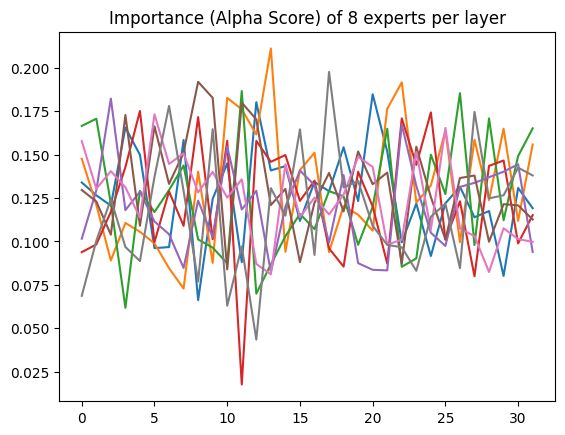

In [76]:
plt.plot(scores)
plt.title("Importance (Alpha Score) of 8 experts per layer")

Text(0.5, 1.0, 'Combined metric for all experts')

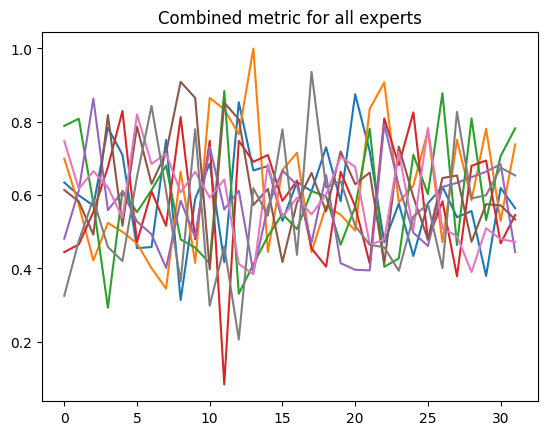

In [79]:
norm_scores = scores / torch.max(scores)
htraces = htraces / torch.max(htraces)
shape = scores.shape
not_clipped_metric = norm_scores
# TODO: select proportionally number of experts
# not_clipped_metric = htraces.expand(shape)
plt.plot(not_clipped_metric)
plt.title("Combined metric for all experts")

tensor([[0.7887],
        [0.8085],
        [0.8633],
        [0.8184],
        [0.8295],
        [0.8204],
        [0.8433],
        [0.7504],
        [0.9090],
        [0.8653],
        [0.8652],
        [0.8839],
        [0.8534],
        [1.0000],
        [0.7093],
        [0.7792],
        [0.7155],
        [0.9361],
        [0.7306],
        [0.7190],
        [0.8753],
        [0.8352],
        [0.9075],
        [0.7321],
        [0.8257],
        [0.7832],
        [0.8781],
        [0.8270],
        [0.8092],
        [0.7812],
        [0.7066],
        [0.7821]])


Text(0.5, 1.0, 'Active expert per layer')

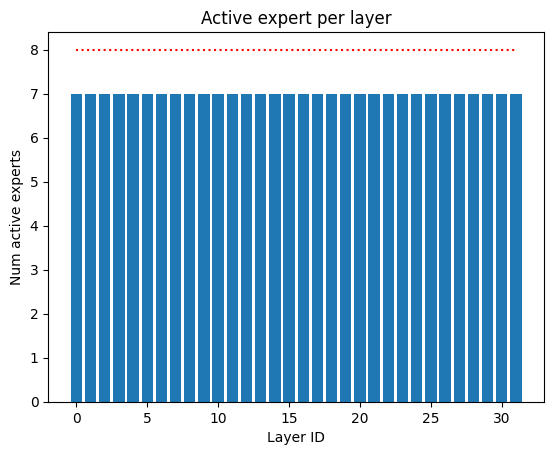

In [91]:
ratio = 2/8
min_num_experts_per_layer = 1
max_metric = not_clipped_metric.max().item()
shape = not_clipped_metric.shape
values, indices = torch.topk(not_clipped_metric, k=min_num_experts_per_layer, largest=False)
pruning_masks = torch.ones(shape).scatter(1, indices, 0)
# mask
# num_values = metric.numel()
# border_idx = int(num_values * ratio)
# threshold = metric.reshape([-1, 1]).sort(dim=0)[0][border_idx]

# layers = list(range(32))
# fig, ax = plt.subplots()
# for i in range(8):
#     ax.scatter(layers, metric[:, i])
# ax.axhline(threshold, color='black', linestyle='dotted')
# plt.title(f"With clipped top-{min_num_experts_per_layer} experts")

# pruning_masks = torch.where(metric>=threshold, 1, 0)
fig, ax = plt.subplots(label='Number of active experts per layer')
ax.bar(x=list(range(32)), height=pruning_masks.sum(dim=1))
ax.plot(torch.ones_like(pruning_masks).sum(dim=1), color='red', linestyle='dotted')
plt.xlabel("Layer ID")
plt.ylabel("Num active experts")
plt.title("Active expert per layer")


In [ ]:
t = torch.ones(32, 8).fill_(8)
tt = htraces * t
tt = tt.int()
plt.plot(tt)

In [47]:
shape = not_clipped_metric.shape
num_to_prune = 2
# num_values = not_clipped_metric.numel()
values, indices = torch.topk(not_clipped_metric, k=num_to_prune, largest=False)
indices.shape
# pruning_mask = torch.ones(shape).scatter(1, indices, 0)
# TODO: not valid after reshape. still 8 experts, but 2 different experts on each layer are disabled
# to_draw = not_clipped_metric[not_topk_indices].reshape(32,6)
# metric = not_clipped_metric.scatter(1, indices, 0)
# pruning_masks
# border_idx = int(num_values * ratio)
# threshold = metric.reshape([-1, 1]).sort(dim=0)[0][border_idx]
# pruning_masks = torch.where(scores>=threshold, 1, 0)

# fig, ax = plt.subplots(label='Number of active experts per layer')
# ax.bar(x=list(range(32)), height=pruning_masks.sum(dim=1))
# ax.plot(torch.ones_like(pruning_masks).sum(dim=1), color='red', linestyle='dotted')
# plt.xlabel("Layer ID")
# plt.ylabel("Num active experts")
# plt.title("Active expert per layer")
# # plt.close()


torch.Size([32, 2])